In [1]:
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")
%matplotlib inline

mpl.rcParams["savefig.dpi"] = 200
# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
calibration_curve_base_dir = Path("..")/"../calibration_curve/"
calibrated_table_dir = Path("..")/"../tables/"
uncalibrated_table_dir = Path("..")/"../uncalibrated_tables/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

In [2]:
legend_order = ['bravo    | p=0.7 ',
                'bravo    | p=0.55 ',
                'bravo    | p=0.52 ',
                'bravo    | p=0.51 ',
                'bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.52 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian_with_replacement | a=1 | b=1 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        print(name)
        assert False

def reorder_df(df):
    return df.loc[sorted(df.index, key=get_position)]

mpl.rcParams["figure.figsize"] = [8, 6]

def read_csv(file_path, reorder=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [3]:
cols = sns.color_palette("bright", 6)
cs_dict = {'bayesian | a=1 | b=1':cols[0],
           'bayesian_with_replacement | a=1 | b=1':cols[0],
           'bravo    | p=0.55':cols[1],
           'bravo    | p=0.7':cols[1],
           'bravo_without_replacement | p=0.55':cols[2],
           'bravo_without_replacement | p=0.7':cols[2],
           'clip    ':cols[3], 
           'max_sprt':cols[4],
           'truncated_bayesian | a=1 | b=1':cols[5]}

# ls_dict = {'bayesian | a=1 | b=1':'-',
#            'bayesian_with_replacement | a=1 | b=1':'--',
#            'bravo    | p=0.55':'-',
#            'bravo    | p=0.7':'--',
#            'bravo_without_replacement | p=0.55':'-',
#            'bravo_without_replacement | p=0.7':'--',
#            'clip    ':'--', 
#            'max_sprt':'--',
#            'truncated_bayesian | a=1 | b=1':'--'}
ls_dict = {'bayesian | a=1 | b=1':'-',
           'bayesian_with_replacement | a=1 | b=1':'-',
           'bravo    | p=0.55':'-',
           'bravo    | p=0.7':'-',
           'bravo_without_replacement | p=0.55':'-',
           'bravo_without_replacement | p=0.7':'-',
           'clip    ':'-', 
           'max_sprt':'-',
           'truncated_bayesian | a=1 | b=1':'-'}

ms_dict = {'bayesian | a=1 | b=1':'o',
           'bayesian_with_replacement | a=1 | b=1':'s',
           'bravo    | p=0.55':'<',
           'bravo    | p=0.7':'>',
           'bravo_without_replacement | p=0.55':'P',
           'bravo_without_replacement | p=0.7':'X',
           'clip    ':'o', 
           'max_sprt':'o',
           'truncated_bayesian | a=1 | b=1':'o'}

In [4]:
def map_styles(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        ls.append(ls_dict[legend])
        cs.append(cs_dict[legend])
        ms.append(ms_dict[legend])
    return cs, ls, ms

In [5]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (5, 1, 1, 1),
    
    (2, 2, 3, 1.5),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [6]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p', value_name='expected_sample')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    return data_long

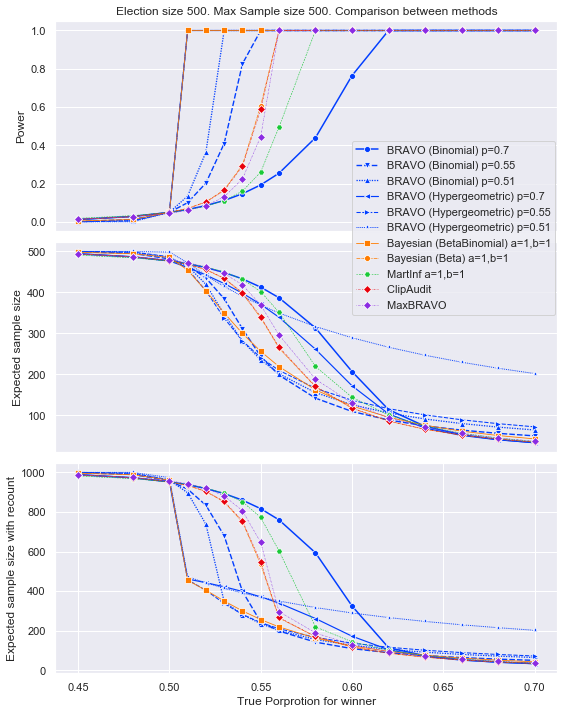

In [7]:
# 1. Basic 500/500 plot without replacement

# data
election = Election(500, 500, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(311)
ax.set_title("Election size 500. Max Sample size 500. Comparison between methods")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")
plt.savefig('../../figures/roc_mean_sample_500.png')

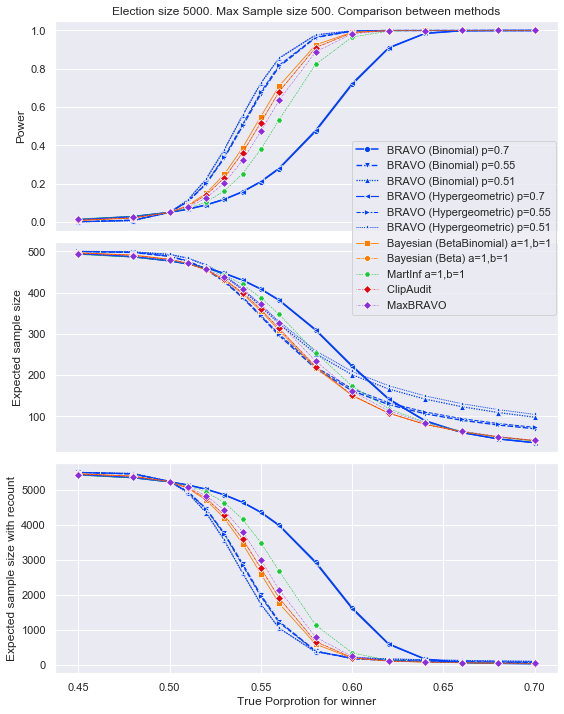

In [8]:
# 1. Basic 5000/500 plot without replacement

# data
election = Election(5000, 500, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(311)
ax.set_title("Election size 5000. Max Sample size 500. Comparison between methods")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")
plt.savefig('../../figures/roc_mean_sample_5000.png')

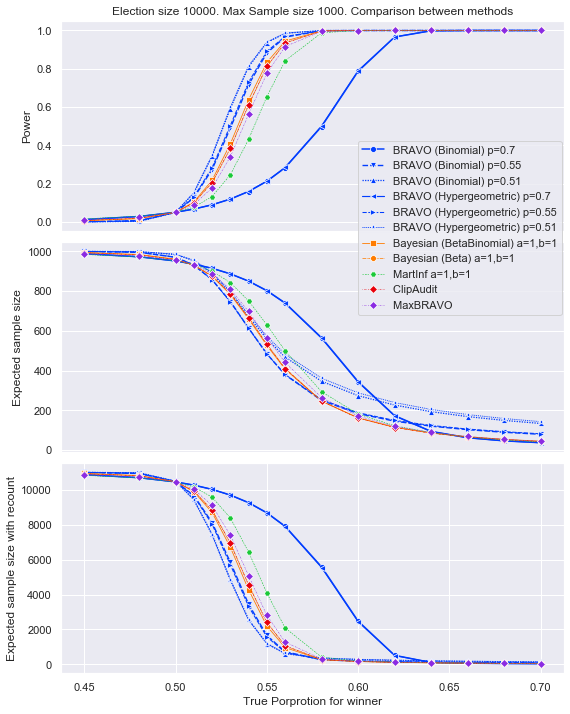

In [9]:
# 1. Basic 10000/1000 plot without replacement

# data
election = Election(10000, 1000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(311)
ax.set_title("Election size 10000. Max Sample size 1000. Comparison between methods")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")
plt.savefig('../../figures/roc_mean_sample_10000.png')

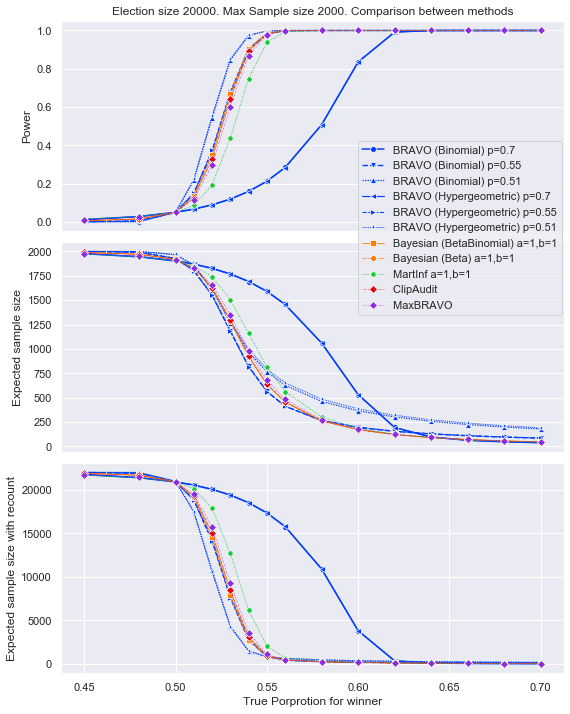

In [10]:
# 1. Basic 20000/2000 plot without replacement

# data
election = Election(20000, 2000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(311)
ax.set_title("Election size 20000. Max Sample size 2000. Comparison between methods")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")
plt.savefig('../../figures/roc_mean_sample_20000.png')

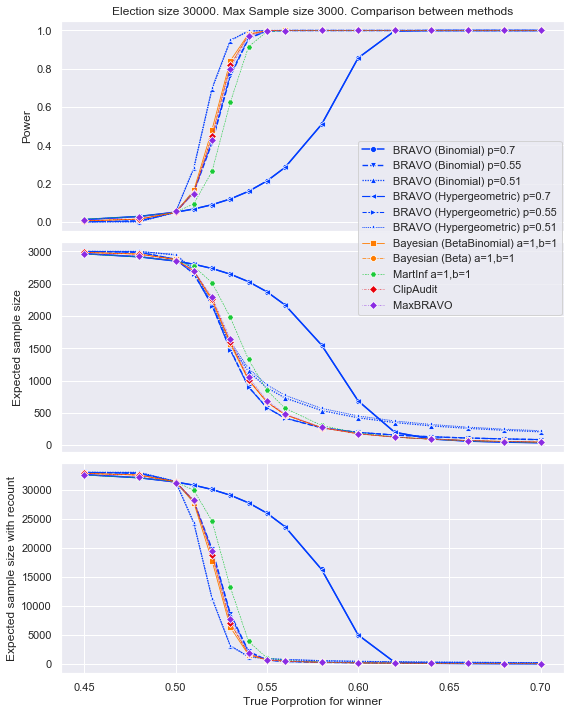

In [11]:
# 1. Basic 30000/3000 plot without replacement

# data
election = Election(30000, 3000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(311)
ax.set_title("Election size 30000. Max Sample size 3000. Comparison between methods")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
make_legend(data_long, ax, bbox_to_anchor=(0.59, 0.43), loc=2, borderaxespad=0.)


data_type = "unconditional_mean.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax = fig.add_subplot(312)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)

data_type = "unconditional_mean_with_recount.csv"
data_path = calibrated_table_dir/str(election)/data_type
data_long = prep_long_df(read_csv(data_path))

ax.xaxis.set_visible(False)
ax.set_ylabel("Expected sample size")

ax = fig.add_subplot(313)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'basename',
    size = 'parameter_with_type',
    style= 'parameter_with_type',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_zorder(-1)
plt.subplots_adjust(hspace=0.05)

ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Expected sample size with recount")
plt.savefig('../../figures/roc_mean_sample_30000.png')

# Calibration curve

#### Uncalibrated vs calibrated

In [30]:
election = Election(20000, 2000, 0.5, 1, False)
election = Election(10000, 1000, 0.5, 1, False)
data_type = "power.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['calibration'] = True
data_path2 = uncalibrated_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['calibration'] = False
# data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.7"'),
#              data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.7"')])
data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)"'),
             data_long2.query('basename_with_type == "BRAVO (Hypergeometric)"')])
data_long[data_long['p'] == 0.5]

,legend,p,expected_sample,type,basename,basename_with_type,parameter,parameter_with_type,calibration
25,bravo_without_replacement | p=0.7 | alpha=0.05...,0.5,0.049840,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.7,Hypergeometric p=0.7,True
26,bravo_without_replacement | p=0.55 | alpha=0.0...,0.5,0.049853,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,True
27,bravo_without_replacement | p=0.51 | alpha=0.3...,0.5,0.049217,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.51,Hypergeometric p=0.51,True
20,bravo_without_replacement | p=0.7 | alpha=0.05,0.5,0.043497,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.7,Hypergeometric p=0.7,False
21,bravo_without_replacement | p=0.55 | alpha=0.05,0.5,0.042010,Hypergeometric,BRAVO,BRAVO (Hypergeometric),p=0.55,Hypergeometric p=0.55,False


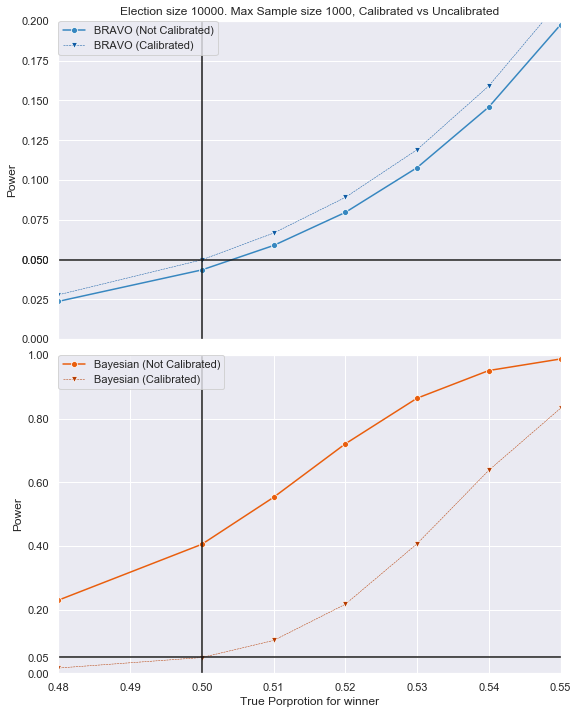

In [23]:
# 3. Comparison between calibration and uncalibration
# Specifically made for expected count for bravo
# data
election = Election(10000, 1000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "power.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['calibration'] = True
data_path2 = uncalibrated_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['calibration'] = False

data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.7"'),
             data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.7"')])

ax = fig.add_subplot(211)
ax.set_title("Election size 10000. Max Sample size 1000, Calibrated vs Uncalibrated")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'calibration',
    size = 'calibration',
    style= 'calibration',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette("Blues", 5)[-2:], 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
ax.set_xlim([0.48, 0.55])
ax.set_ylim([0, 0.2])
plt.yticks(list(plt.yticks()[0]) + [0.05])
plt.axvline(0.5, c='k')
plt.axhline(0.05, c='k')
plt.legend(['BRAVO (Not Calibrated)', 'BRAVO (Calibrated)'], bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)


data_long = pd.concat([data_long1.query('(basename_with_type == "Bayesian (BetaBinomial)")'),
             data_long2.query('(basename_with_type == "Bayesian (BetaBinomial)")')])

ax = fig.add_subplot(212)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'calibration',
    size = 'calibration',
    style= 'calibration',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Power")
plt.yticks(list(plt.yticks()[0]) + [0.05])
ax.set_xlim([0.48, 0.55])
ax.set_ylim([0, 1])
plt.axvline(0.5, c='k')
plt.axhline(0.05, c='k')
plt.legend(['Bayesian (Not Calibrated)', 'Bayesian (Calibrated)'], bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(hspace=0.05)

plt.savefig('../../figures/calibration_power.png')

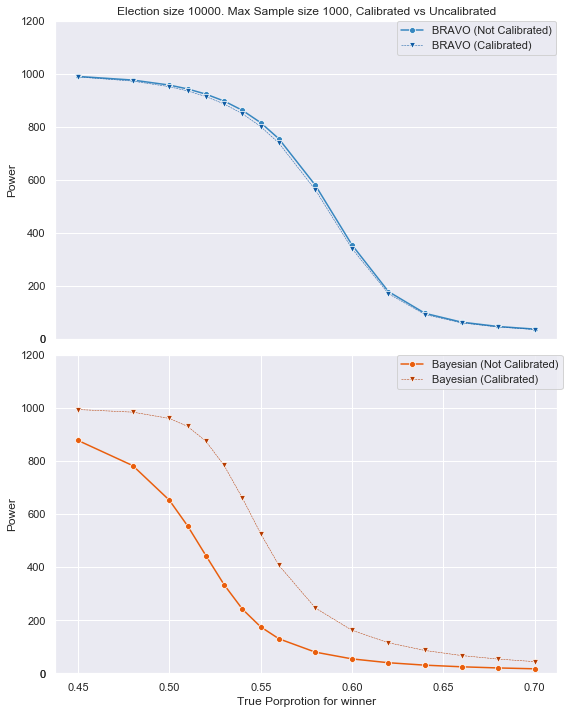

In [21]:
# 3. Comparison between calibration and uncalibration
# Specifically made for expected count for bravo
# data
election = Election(10000, 1000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

data_type = "unconditional_mean.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['calibration'] = True
data_path2 = uncalibrated_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['calibration'] = False

data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.7"'),
             data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.7"')])

ax = fig.add_subplot(211)
ax.set_title("Election size 10000. Max Sample size 1000, Calibrated vs Uncalibrated")

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'calibration',
    size = 'calibration',
    style= 'calibration',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette("Blues", 5)[-2:], 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")
ax.set_ylim([0, 1050])
plt.yticks(list(plt.yticks()[0]) + [0.05])
plt.legend(['BRAVO (Not Calibrated)', 'BRAVO (Calibrated)'], bbox_to_anchor=(0.68,1), loc=2, borderaxespad=0.)


data_long = pd.concat([data_long1.query('(basename_with_type == "Bayesian (BetaBinomial)")'),
             data_long2.query('(basename_with_type == "Bayesian (BetaBinomial)")')])

ax = fig.add_subplot(212)

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'calibration',
    size = 'calibration',
    style= 'calibration',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Power")
ax.set_ylim([0, 1050])
plt.yticks(list(plt.yticks()[0]) + [0.05])
plt.legend(['Bayesian (Not Calibrated)', 'Bayesian (Calibrated)'], bbox_to_anchor=(0.68, 1), loc=2, borderaxespad=0.)
plt.subplots_adjust(hspace=0.05)

plt.savefig('../../figures/calibration_expected_size.png')

In [23]:
# Calibration Curve
# 1. Basic 5000/500 plot without replacement
# data
election = Election(10000, 1000, 0.5, 1, False)
data_path = calibration_curve_base_dir/str(election)

xs = []
ys = []
labels = []
for method_data in data_path.iterdir():
    method, param, _ = method_data.stem.rsplit("_", 2)
    param = param.split("=")[0]
    data_df = pd.read_csv(method_data)
    data_df.columns = [param, method]
    data_df.set_index(param, inplace=True)
    xs += list(data_df.index)
    ys += list(data_df[method])
    labels += [method] * len(data_df.index)
    
data = pd.DataFrame(data = dict(
    xs = xs,
    ys = ys,
    legend = labels
))

legend_order_pair = [
    ('bravo_p=0.7', ('BRAVO (Binomial)', 'p=0.7')),
    ('bravo_p=0.55', ('BRAVO (Binomial)', 'p=0.55')),
    ('bravo_without_replacement_p=0.7', ('BRAVO (Hypergeometric)', 'p=0.7')),
    ('bravo_without_replacement_p=0.55', ('BRAVO (Hypergeometric)', 'p=0.55')), 
    ('bayesian_with_replacement_a=1_b=1_critical', ('Bayesian', '(BetaBinomial) a=1, b=1')), 
    ('bayesian_a=1_b=1_critical', ('Bayesian', '(Beta) a=1, b=1')), 
    ('truncated_bayesian_a=1_b=1_critical', ('MartInf', 'a=1, b=1')),
    ('clip', ('ClipAudit', '')), 
    ('max_sprt', ('MaxBRAVO', '')),
]
legend_order_dict = dict(legend_order_pair)

def get_position(name):
    for i, (legend_pattern, (_, _)) in enumerate(legend_order_pair):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        print(name)
        pass
        assert False

def reorder_df2(df):
    df.set_index('legend', inplace=True)
    return df.loc[sorted(df.index, key=get_position)].reset_index()

data = reorder_df2(data)
data['basename'] = [legend_order_dict[i][0] for i in data['legend']]
data['parameter'] = [legend_order_dict[i][1] for i in data['legend']]

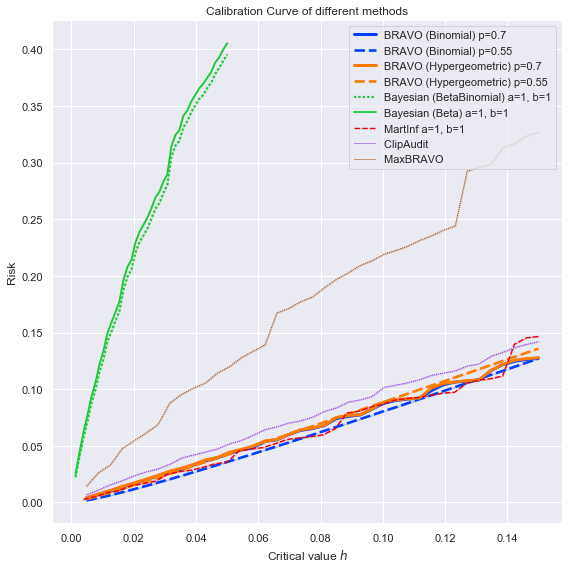

In [42]:
fig = plt.figure(figsize=[8,8])

ax = fig.add_subplot(111)
ax.set_title("Election size 10000. Max Sample size 1000. Calibration curve of methods.")
sns.lineplot(x='xs', 
             y='ys', 
             hue='basename', 
             style='parameter', 
             size='parameter', 
             data=data, 
             markers=False, 
             dashes=dash_styles,
             palette='bright', 
             legend=False, 
             sizes=(1, 3),
             ax=ax)
plt.legend([i[1][0] + ' ' + i[1][1] for i in legend_order_pair])
plt.xlabel('Critical value $h$')
plt.ylabel('Risk')
plt.title('Calibration Curve of different methods')
plt.tight_layout()
plt.savefig('../../figures/calibration_10000.png')

# Compare with/without minstopping

### No min stop

In [ ]:
pdf_path = ('/Users/Dovermore/Documents/Research/AustralianElectionAuditing/AuditAnalysis.nosync/' + 
              'new_calibrate_full/n=001000_m=01000=0.500_replacement=False_step=1/bravo_without_replacement_0.05/bravo_without_replacement_pdf.csv')
cdf_path = ('/Users/Dovermore/Documents/Research/AustralianElectionAuditing/AuditAnalysis.nosync/' + 
              'new_calibrate_full/n=001000=01000=0.500_replacement=False_step=1/bravo_without_replacement_0.05/bravo_without_replacement_cdf.csv')